# Lab3. Training, Deploying and hosting custom model on SageMaker

In this lab, you will run your training job with SageMaker. You will use your CNN architecture and script that you build at Lab2. 

 ## Set up SageMaker environment

* **Please note that the Tensorflow eager mode will be enabled by below code:**
 tf.enable_eager_execution()

In [1]:
from PIL import Image
import json
import os
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe
from sagemaker.tensorflow import TensorFlow

tf.enable_eager_execution()

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::578948193120:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
CPU times: user 149 ms, sys: 12.5 ms, total: 161 ms
Wall time: 209 ms


## Upload data to S3

* Upload files to S3
* It may take several minutes **(5 minutes for 10,000 images)**

In [3]:
bucket = sess.default_bucket() 
prefix = 'anpr'

In [4]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 10,000 files in gen/cropped-imgs folder.
there are 10,000 files in gen/nums-tags folder.
there are 8,000 files in tf/tf-train folder.
there are 8,000 files in tf/tf-train_annotation folder.
there are 2,000 files in tf/tf-validation folder.
there are 2,000 files in tf/tf-validation_annotation folder.


In [5]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train')
s3_validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation')
s3_train_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train_annotation')
s3_validation_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation_annotation')

In [6]:
%%time
!aws s3 rm {s3_train_data} --recursive --only-show-errors
!aws s3 rm {s3_validation_data} --recursive --only-show-errors
!aws s3 rm {s3_train_annotation} --recursive --only-show-errors
!aws s3 rm {s3_validation_annotation} --recursive --only-show-errors

CPU times: user 1.81 s, sys: 273 ms, total: 2.08 s
Wall time: 2min 22s


In [7]:
%%time
!aws s3 cp tf/tf-train {s3_train_data} --include "*_0.png" --recursive --only-show-errors
!aws s3 cp tf/tf-train {s3_train_data} --include "*_1.png" --recursive --only-show-errors

!aws s3 cp tf/tf-validation {s3_validation_data} --recursive --only-show-errors
!aws s3 cp tf/tf-train_annotation {s3_train_annotation} --recursive --only-show-errors
!aws s3 cp tf/tf-validation_annotation {s3_validation_annotation} --recursive --only-show-errors

CPU times: user 2.17 s, sys: 359 ms, total: 2.53 s
Wall time: 2min 42s


* Check upload results 

In [8]:
!aws s3 ls {s3_train_data}/ |wc -l
!aws s3 ls {s3_validation_data}/ |wc -l
!aws s3 ls {s3_train_annotation}/ |wc -l
!aws s3 ls {s3_validation_annotation}/ |wc -l

8000
2000
8000
2000


In [9]:
s3_output_location = 's3://{}/{}/tf-output'.format(bucket, prefix)

## Check data channels

Training data will be copied from S3 to Tensorflow container.  
Refer to the below directory paths.

### Test and validation data directories
1) In this notebook
- train images: './tf/tf-train'
- train annotations: './tf/tf-train_annotations'
- validation images: './tf/tf-validation'
- validation annotations: './tf/tf-validation_annotations'

2) S3
- train images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train'
- train annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation'
- validation images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train_annotations'
- validation annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation_annotations'

**3) Training container (Tensorflow container)**
- **train images: '/opt/ml/input/data/train/'**
- **train annotations: '/opt/ml/input/data/train_annotation/'**
- **validation images: '/opt/ml/input/data/validation/'**
- **validation annotations: '/opt/ml/input/data/validation_annotation/'**

In [10]:
train_data = sagemaker.inputs.TrainingInput(s3_train_data, distribution='FullyReplicated',
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_data, distribution='FullyReplicated',
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.inputs.TrainingInput(s3_train_annotation, distribution='FullyReplicated',
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.inputs.TrainingInput(s3_validation_annotation, distribution='FullyReplicated',
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data,
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}


* Refer to API specs of SDK site
    * https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst
    * https://sagemaker.readthedocs.io/en/latest/using_tf.html
* Refer to the API document 
    * https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html  
   (Note that checkpoint_path, training_steps, evaluation_steps, requirements_file args are not permitted when using Script Mode)

## Check the code of 'cnn_ocr.py' for entry_point
* Thins file will be passed as entry_point when defining Tensorflow Estimator
* Notice that **model() function and get_data_pair() function are exactly same** as Lab2
* Hperparameters are parsed from argparse.ArgumentParser() as they will **be passed as arguments of the python run command line script**.
* In the main function, input data are loaded from local directory **'/opt/ml/input/data/{...channel...}'** thru SM_CHANNEL_... parameters
* In the main function, output model is stored in **'/opt/ml/model'** directory 

In [11]:
!pygmentize cnn_ocr.py

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import concatenate
import os
import argparse

import json
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

from common import JOIN, get_data_pair, model
n_chr=len(JOIN)

def parse_args():
    
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the 

## Run training job
* **This time, we will run 30 epochs. (It may take around 15 minutes)**
* Note that we use p3.2xlarge instance, which will shorten our training time with GPU. 
* To see the detailed message of training job, set the verbose to 1(true).

In [30]:
model_dir = '/opt/ml/model'
#train_instance_type='ml.p3.2xlarge' #8 cores
train_instance_type='ml.g4dn.16xlarge' #64 cores
hyperparameters = {'epochs': 130, #'epochs': 30, 
                   'batch_size': 128,
                   'learning_rate': 0.001,
                   'verbose': 0}

In [31]:
ocr_estimator = TensorFlow(
    entry_point='cnn_ocr.py',
    dependencies=['common.py'],
    role=role,
    model_dir=model_dir,
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type=train_instance_type,
    framework_version='1.12',
    py_version='py3'
)

* Run your training job.
* You will find the below command from the job log.  
```/usr/bin/python cnn_ocr.py --batch_size 128 --epochs 30 --learning_rate 0.001 --model_dir /opt/ml/model --verbose 0```

In [32]:
%%time
ocr_estimator.fit(data_channels, logs=True)

2021-07-17 16:27:54 Starting - Starting the training job...
2021-07-17 16:28:17 Starting - Launching requested ML instancesProfilerReport-1626539273: InProgress
......
2021-07-17 16:29:17 Starting - Preparing the instances for training......
2021-07-17 16:30:17 Downloading - Downloading input data...............
2021-07-17 16:32:48 Training - Training image download completed. Training in progress..2021-07-17 16:32:52,084 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-07-17 16:32:52,438 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "validation_annotation": "/opt/ml/input/data/validation_annotation",
        "train_annotation": "/opt/ml/input/data/train_annotation",
        "validation": "/opt/ml/input/data/validation",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensor

* Check the model name that training job just created
* Check the model file that training job just created

In [33]:
print(ocr_estimator.output_path)
print(ocr_estimator.model_data)

!aws s3 ls {ocr_estimator.model_data}

s3://sagemaker-us-east-1-578948193120/
s3://sagemaker-us-east-1-578948193120/sagemaker-tensorflow-scriptmode-2021-07-17-16-27-53-593/output/model.tar.gz
2021-07-17 16:54:11   18681944 model.tar.gz


## Deploy the model and inference Test

* Now, let's deploy our model into SageMaker's inference hosting environment 

In [34]:
#predictor = sagemaker.predictor.Predictor.update_endpoint()
predictor = ocr_estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge',
                                 accelerator_type='ml.eia2.medium')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------------!

* Check the result of deploy

In [35]:
predictor.endpoint_name

'sagemaker-tensorflow-scriptmode-2021-07-17-16-54-31-069'

## Test data

* Prepare character list and test images

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
from common import JOIN, IMAGE_WIDTH, IMAGE_HEIGHT

In [38]:
test_imgs = os.listdir('tf/tf-validation')

* Check the prediction of 10 sample pairs of images

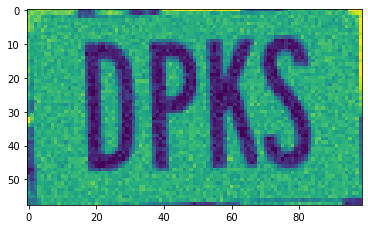

0
['S', 'P', 'K', '5', ' ', ' ', ' ']


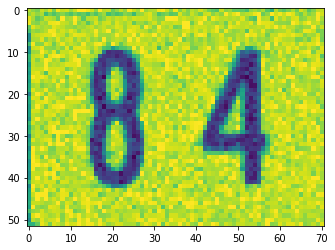

1
['8', '4', ' ', ' ', ' ', ' ', ' ']


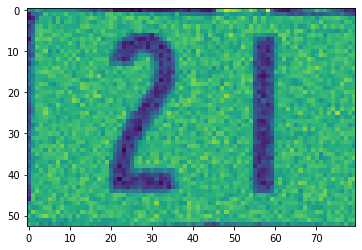

2
['Q', '1', ' ', ' ', ' ', ' ', ' ']


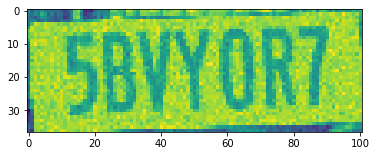

3
['B', 'P', 'P', 'F', 'B', 'S', ' ']


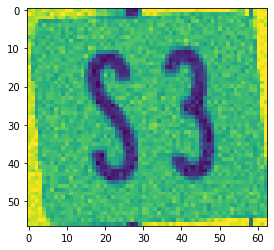

4
['S', 'S', ' ', ' ', ' ', ' ', ' ']


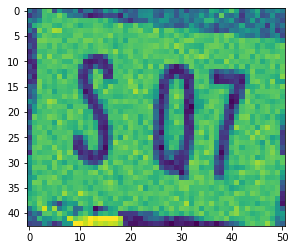

5
['S', '0', 'O', ' ', ' ', ' ', ' ']


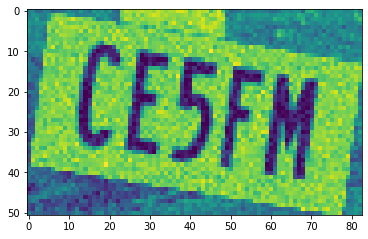

6
['C', 'T', '5', 'T', 'Y', ' ', ' ']


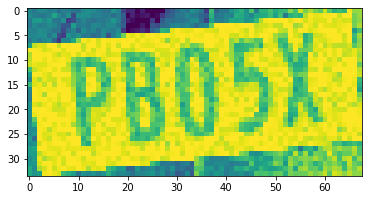

7
['9', 'B', 'Q', 'S', 'Z', ' ', ' ']


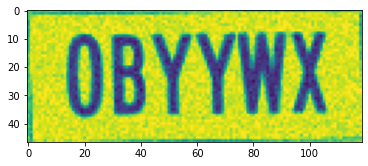

8
['W', 'Y', 'Y', 'O', 'W', 'W', ' ']


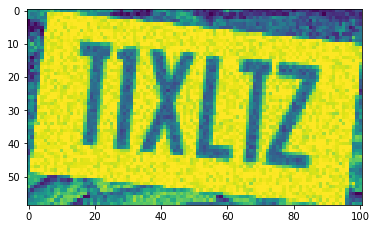

9
['T', 'X', 'U', 'Z', 'Z', ' ', ' ']


In [39]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((IMAGE_WIDTH,IMAGE_HEIGHT)))
    input = {
      'instances': val_img_np.reshape([1,IMAGE_WIDTH,IMAGE_HEIGHT,1])/255.
    }
    prediction = predictor.predict(input)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction['predictions'][0]['d1'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d2'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d3'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d4'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d5'])],  
              JOIN[np.argmax(prediction['predictions'][0]['d6'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d7'])]]
    print(digits)

## Endpoint API test

* You may invoke SageMaker endpoint from business application as below:

In [40]:
import boto3
from sagemaker.predictor import json_deserializer

#Deprecated
#from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON

CONTENT_TYPE_JSON = "application/json"
CONTENT_TYPE_CSV = "text/csv"

runtime = boto3.Session().client('runtime.sagemaker')
tf_endpoint = predictor.endpoint_name

In [41]:
api_predictor = sagemaker.predictor.Predictor(endpoint_name=tf_endpoint, sagemaker_session=sess, serializer=sagemaker.serializers.JSONSerializer(),
                                content_type=CONTENT_TYPE_JSON, accept=CONTENT_TYPE_CSV)
api_response = json.loads(api_predictor.predict(input))
print(JOIN[np.argmax(api_response['predictions'][0]['d1'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d2'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d3'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d4'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d5'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d6'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d7'])] )

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


TXUZZ  


## Test the trainned model in local (Optional)
Let's extport your trained model from S3 and deploy it to local (this notebook). 

* Copy trainned model from S3 to ./model folder

In [42]:
#!rm -Rf model
!aws s3 cp {ocr_estimator.model_data} ./model/model.tar.gz --region {sess.boto_region_name}

download: s3://sagemaker-us-east-1-578948193120/sagemaker-tensorflow-scriptmode-2021-07-17-16-27-53-593/output/model.tar.gz to model/model.tar.gz


* Extract the model file and see the components

In [43]:
!tar -xvzf ./model/model.tar.gz -C ./model

1626540846/
1626540846/variables/
1626540846/variables/variables.data-00000-of-00001
1626540846/variables/checkpoint
1626540846/variables/variables.index
1626540846/saved_model.pb
1626540846/assets/
1626540846/assets/saved_model.json
weights.ckpt.index
checkpoint
weights.ckpt.data-00000-of-00001


* Define model architecture locally (same as Lab2)

In [44]:
from common import model, IMAGE_WIDTH, IMAGE_HEIGHT

* Read and restore model from downloaded checkpoint

In [45]:
tf.keras.backend.clear_session()

local_model = model((IMAGE_WIDTH,IMAGE_HEIGHT,1))
saver = tfe.Saver(local_model.variables)
saver.restore('model/weights.ckpt')

INFO:tensorflow:Restoring parameters from model/weights.ckpt


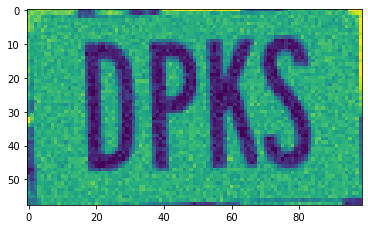

['S', 'P', 'K', '5', ' ', ' ', ' ']


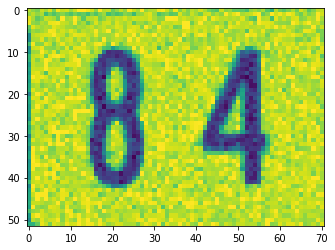

['8', '4', ' ', ' ', ' ', ' ', ' ']


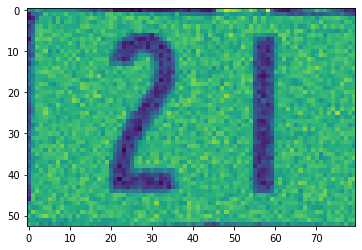

['Q', '1', ' ', ' ', ' ', ' ', ' ']


In [46]:
for i in range(3):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((IMAGE_WIDTH,IMAGE_HEIGHT)))
    prediction = local_model.predict(val_img_np.reshape([1,IMAGE_WIDTH,IMAGE_HEIGHT,1])/255.)
    plt.imshow(val_img)
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][0])], 
              JOIN[np.argmax(prediction[1][0])], 
              JOIN[np.argmax(prediction[2][0])], 
              JOIN[np.argmax(prediction[3][0])], 
              JOIN[np.argmax(prediction[4][0])], 
              JOIN[np.argmax(prediction[5][0])], 
              JOIN[np.argmax(prediction[6][0])]]
    print(digits)

* You may utilize above code to build your own inference environment

## Going further
You must not be satisfied with the results yet. There are still a lot of misclassification. (In the final test results, character '누' is recongnized as '수'.)  
We may further refine our model by the following ways:
* Adding more training images and more epochs
* Adding real world license plate images
* Changing an architecture to another structure (ex: CNN + LSTM)
* Combining Object detection and this OCR model into one CNN architecture (Usually, end-to-end approach needs more training data)
    
In our case, adding more training data is the first improvement we can try. Below is the result that I added more training data and tested with 100,000 images. You can see the result was improved with more training data.

<br />
  
<img src='imgs/finalresult.png' stype='width:600px;'/>

## Delete Endpoint

In [47]:
sagemaker.Session().delete_endpoint(predictor.endpoint_name)

## Next step
**Don't forget to delete resources** (Any endpoints, Notebook instance, and S3 bucket) as a final step.  
Thank you for your participation.   
